In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as col
import sys
sys.path.append('/pool/firebolt1/p484/projects/huang/rings')
from continuumanalysis3 import Continuum
from fitellipse import *
from skimage import transform, measure
from analyzeradprofile import *

In [2]:
disk =  {'filename': '/data/sandrews/jhfiles/LPfiles/taperedimages/WaOph6_tapered.image.fits',
                          'distance':123,
                          'incl' : 46.2,
                          'PA' : 171, 
                          'offsetx' : -82.4*.003,
                          'offsety' : -118.5*.003,
                          'size': 2,
                          'gamma': 0.5}
maxrad = 125
radialbins = 0.5+1*np.arange(maxrad)

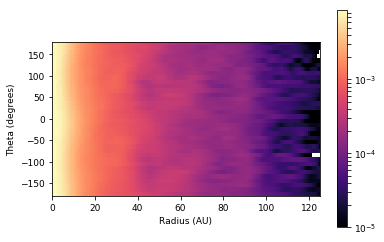

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


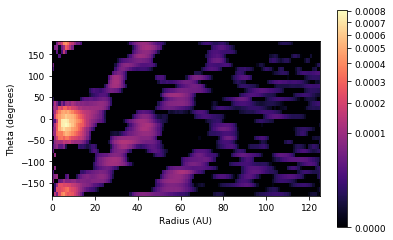

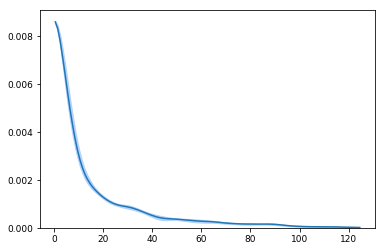

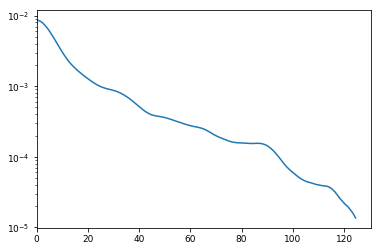

In [2]:

cont = Continuum(disk['filename'], disk['offsetx'],disk['offsety'], disk['PA'], disk['incl'], disk['distance'])

surfbrightness, SB_scatter, rtmap = cont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.2, origin = 'lower', cmap = 'magma', norm = col.LogNorm(vmin = 1.e-5))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.imshow(rtmap-np.mean(rtmap, axis = 0),extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.2, origin = 'lower', cmap = 'magma', norm = col.PowerNorm(vmin = 0, gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.plot(radialbins, surfbrightness)
plt.fill_between(radialbins,(surfbrightness - SB_scatter),(surfbrightness + SB_scatter),facecolor = '#B2D1FF',edgecolor = '#B2D1FF')
plt.ylim(ymin =0)

plt.show()

plt.semilogy(radialbins, surfbrightness)
plt.xlim(xmin = 0)
plt.show()



/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = -2.436e-01 arcsec, delta_y = -3.606e-01 arcsec
The MLE semi-major axis is r = 0.712 arcsec
The MLE inclination is i = 47.270 degrees
The MLE position angle is PA = 174.238 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.582e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


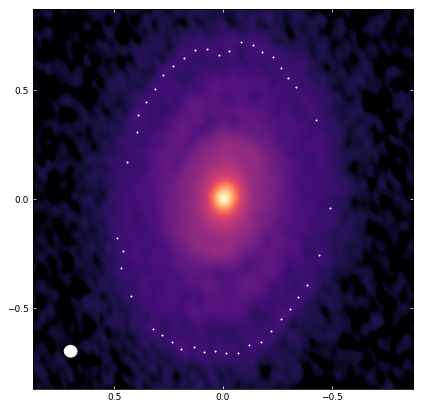

In [3]:
# Extract the ring that's at ~85 AU
xcoords1, ycoords1 = cont.extract_ring(82,92,tbins = -177+6*np.arange(60), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords1, ycoords1, 0.4, 1.75)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_1 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     0.7,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords1, ycoords1)

In [4]:
#do mcmc fit
def lnprior(ellipse_params):
    x0, y0, r0, cosi, par, logvar = ellipse_params
    if -4.5 < x0 < 4.5 and -4.5 < y0 < 4.5 and 0 < r0 < 4.5 and 0<cosi<1 and np.pi/2 < par < 3*np.pi/2 and -15<logvar<-5:
        return 0.0
    return -np.inf

def lnprob(ellipse_params, xcoord, ycoord):
    lp = lnprior(ellipse_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(ellipse_params, xcoord, ycoord)

nwalkers = 30
nthreads = 8
nsteps = 20000
sampler1 = run_mcmc(nwalkers, nthreads, nsteps, mle_1, lnprob, xcoords1, ycoords1)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

In [10]:
sampler1.acor

array([ 76.17688331,  57.58902093,  70.43399346,  65.03022229,
        82.54496817,  85.93862384])

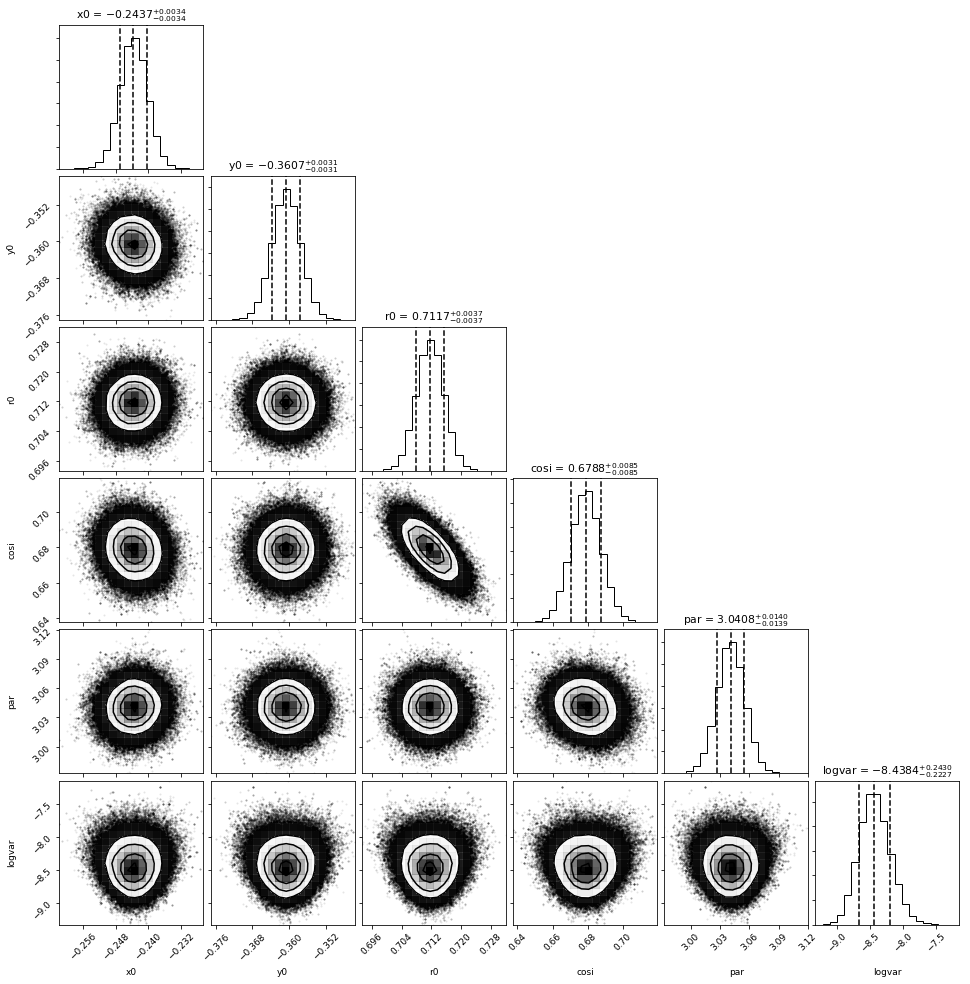

The x offset is delta_x = -2.44e-01 arcsec (+3.4e-03, -3.4e-03)
The y offset is delta_y = -3.61e-01 arcsec (+3.1e-03, -3.1e-03)
The median semi-major axis is r = 0.7117 arcsec (+0.0037, -0.0037) 
or 87.54 AU (+0.38, -0.38)
The incl is i = 47.25 deg (+0.66, -0.67)
The median position angle is PA = 174.22 deg (+0.80, -0.80)
The median log-variance in the pixel offsets from the true ellipse is -8.438e+00


In [5]:
plot_corner(sampler1, 500, 1)
sampler_results(sampler1, 500, cont.src_distance)

In [13]:
np.savez("WaOph6ellipsechains.npz", BR88 = sampler1.chain)

In [3]:
radialbins = 0.5+np.arange(0, maxrad)
#make some preliminary plots
newcont = Continuum(disk['filename'], -0.2436,-0.3606, 174.2, 47.3,disk['distance'])
    
newsurfbrightness, newSB_scatter, newrtmap = newcont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))


print("max",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'max'))
print("min",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'min'))

max [86]
min [80]


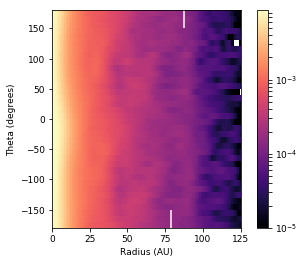

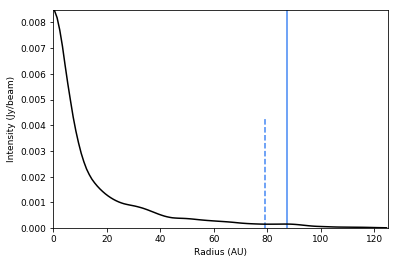

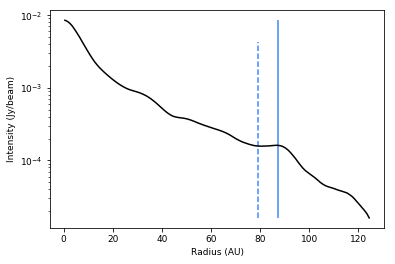

(0, 125)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


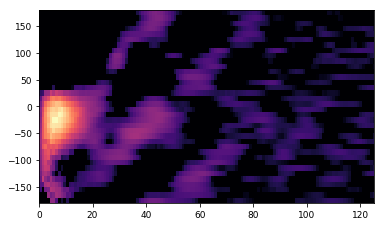

In [11]:


plt.imshow(newrtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma',  norm = col.LogNorm(vmin = 1.e-5))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
features = np.array([])
gaps = np.array([79])
rings = np.array([87.5])
for gap in gaps:
    plt.vlines(gap,-180,-150, color ='white')
for ring in rings:
    plt.vlines(ring,150,180, color ='white')
for f in features:
    plt.vlines(f,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='gray')

plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()


plt.plot(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 0, xmax = maxrad)
plt.ylim(ymin = np.min(newsurfbrightness), ymax = np.max(newsurfbrightness))
plt.show()

plt.semilogy(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),np.max(newsurfbrightness), color ='#4286f4')
for f in features:
    plt.vlines(f,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='gray')

plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.show()

plt.imshow(newrtmap-newsurfbrightness,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.2, origin = 'lower', cmap = 'magma', norm = col.PowerNorm(vmin = 0,gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)



In [4]:
calc_contrast(79.001, 87.5, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.97748873042803175, 0.026646459049796331)

In [5]:
measure_widths(79.001, 87.5, radialbins, newsurfbrightness, 61,99)

0.000159491758366 84.6


(6.7000000000000028, 3.5999999999999943)

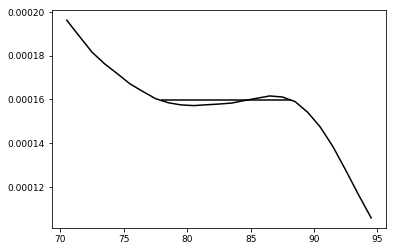

In [8]:
plt.plot(radialbins[70:95], newsurfbrightness[70:95], color = 'black')
plt.hlines(0.000159491758366, 84.6-6.7,84.6)
plt.hlines(0.000159491758366, 84.6,84.6+3.6)

102.5


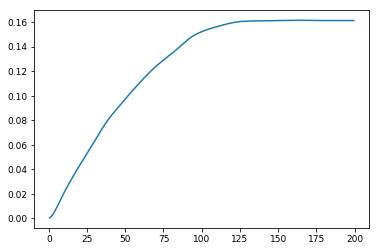

In [5]:
bins = 0.5+1*np.arange(0, 200)

cumeflux = newcont.cumefluxprofile(bins)

plt.plot(bins, cumeflux)
print(bins[np.argmin(np.abs(cumeflux-0.95*np.max(cumeflux)))])